# SYDE 556/750 --- Assignment 3
**Student ID: 20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
# I added some random stuff that i lost track of - added these to make the 
# plots look nicer but failed to do it so i just left it here
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Change Seed whenever needed to get reproducible results
seed  = 20854840

# Fix the numpy random seed for reproducible results
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [2]:
def calc_rmse(x1, x2):
    return np.sqrt(np.mean((x1 - x2) ** 2))
     

def randComplex():
    return np.random.normal() + np.random.normal() * 1j

#If symmetry exists, it returns a boolean indicating its existence and the index where the symmetric element is located.
def symmetryExists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)

# Calculate signal RMS
def signalRMS(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))

# Calculates the current RMS of the signal and then scales all elements to achieve the desired RMS.
def rescaleSignal(signal, idealRMS):
    currentRMS = signalRMS(signal)
    rescaledSignal = [p * idealRMS / currentRMS for p in signal]
    return rescaledSignal

def locations(index):
    return int(index[0])

# It's a way to ensure that the frequency domain and signal values remain aligned.
def tuplify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))

def calcRmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))

def generate_signal(T, dt, rms, limit, seed):

    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = randComplex()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetryExists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescaleSignal(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = tuplify(F, Z)
    return z, Z


# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

Text(0, 0.5, ' Firing Rate $a_{max}$(Hz)')

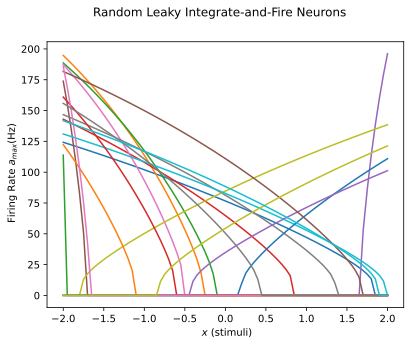

In [3]:
class LIFNeuron:
    e_vals = [-1,1]

    def __init__(self, tau_ref=0.002, tau_rc=0.02):
        self.x_int = np.random.uniform(-2,2)
        self.max_fire_rate = np.random.uniform(100,200)
        self.encoder = np.random.choice(self.e_vals)
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        J_max = 1/(1 - np.exp((tau_ref - 1/self.max_fire_rate)/tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int

    def set_vars(self, enc, alpha, j_bias):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = j_bias
    
    def print_vars(self):
        print(self.__dict__)

    def rates(self, x):
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates
    
    def spikes(self, x, dt):
        
        num_ref_steps = np.floor(self.tau_ref/dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha*stim*self.encoder + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1: #spike
                v = 1 #constant spike voltage
                ref_count = num_ref_steps
                spike_count +=1
            elif v < 0: #keep positive
                v = 0
            
            if v == 1:
                spikes.append(1)
            else:
                spikes.append(0)
                
            v_next = v + dt*(1/self.tau_rc)*(J - v)
            voltages.append(v)
            v = v_next
        
        return voltages, spike_count, spikes
    
class LIFNeuronR1:
    e_vals = [-1,1]

    def __init__(self, tau_ref=0.002, tau_rc=0.02):
        self.x_int = np.random.uniform(-1,1)
        self.max_fire_rate = np.random.uniform(100,200)
        self.encoder = np.random.choice(self.e_vals)
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        J_max = 1/(1 - np.exp((tau_ref - 1/self.max_fire_rate)/tau_rc))
        self.alpha = (J_max - 1)/(1 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int

    def set_vars(self, enc, alpha, j_bias):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = j_bias
    
    def print_vars(self):
        print(self.__dict__)

    def rates(self, x):
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates
    
    def spikes(self, x, dt):
        
        num_ref_steps = np.floor(self.tau_ref/dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha*stim*self.encoder + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1: #spike
                v = 1 #constant spike voltage
                ref_count = num_ref_steps
                spike_count +=1
            elif v < 0: #keep positive
                v = 0
            
            if v == 1:
                spikes.append(1)
            else:
                spikes.append(0)
                
            v_next = v + dt*(1/self.tau_rc)*(J - v)
            voltages.append(v)
            v = v_next
        
        return voltages, spike_count, spikes

def generate_LIF_neurons(num, stimuli):
    neurons = []
    rates = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
        rates.append(n.rates(stimuli))
    return neurons, rates

plt.figure()
plt.suptitle('Random Leaky Integrate-and-Fire Neurons')

num_neurons = 20
S = 81 # Number of samples
x = np.linspace(-2,2,S)
neurons, rates = generate_LIF_neurons(num_neurons, x)

for neuron, nrate in zip(neurons, rates):
    plt.plot(x, nrate)

plt.xlabel(' $x$ (stimuli)')
plt.ylabel(' Firing Rate $a_{max}$(Hz)')


**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

Text(0.5, 0, 'Represented value $x$')

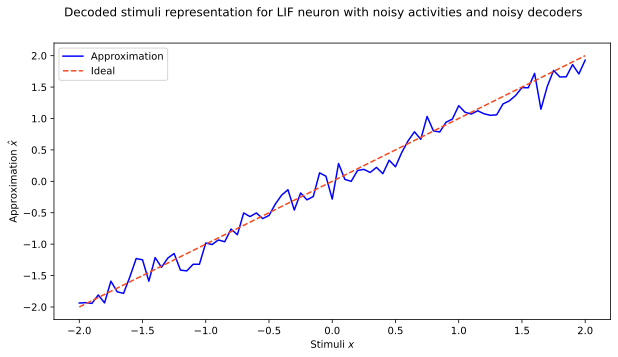

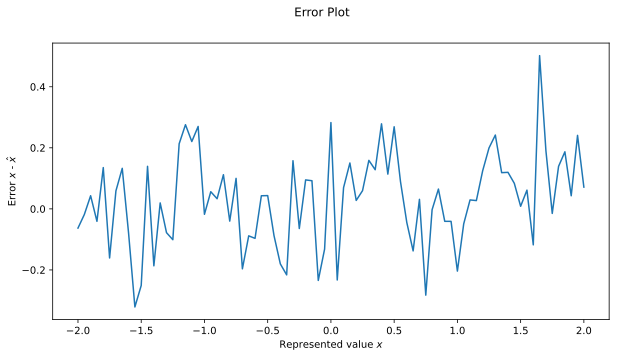

In [4]:
A = np.transpose(rates)
stddev_noise = 0.1*200
gamma_noisy = np.dot(np.transpose(A),A)/S + np.power(stddev_noise,2)*np.identity(A.shape[1])
upsilon = np.dot(np.transpose(A),x)/S
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

gauss_noise = np.random.normal(scale=stddev_noise,size=np.shape(A))
x_approx = np.dot(A + gauss_noise,decoders)
plt.figure(figsize=(10,5))
plt.suptitle('Decoded stimuli representation for LIF neuron with noisy activities and noisy decoders')
plt.plot(x,x_approx,color="blue", label="Approximation")
plt.plot(x,x,color='xkcd:reddish orange', linestyle="dashed", label="Ideal")
plt.xlabel("Stimuli $x$")
plt.ylabel("Approximation $\hat x$")
plt.legend()

error = x - x_approx

plt.figure(figsize=(10,5))
plt.suptitle("Error Plot")
plt.plot(x,error)
plt.ylabel("Error $x$ - $\hat x$")
plt.xlabel("Represented value $x$")

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_6908/344596861.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


Text(0, 0.5, 'Gain')

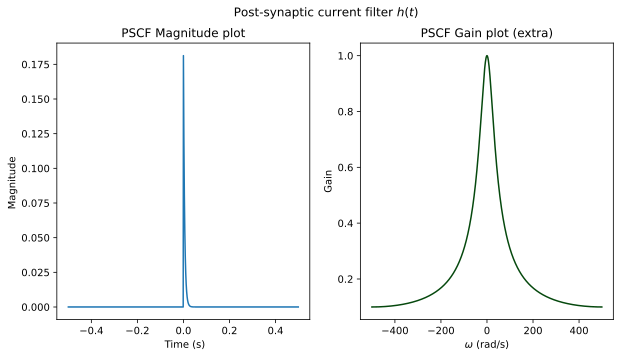

In [5]:
# Find neuron at x = 0 witih 20-50 Hz
zero_index = np.where(x == 0)[0][0]
lt_fifty = np.where(A[zero_index] <= 50)[0]
gt_twenty = np.where(A[zero_index,lt_fifty] >= 20)[0][0]
assert gt_twenty >= 0

neuron = neurons[lt_fifty[gt_twenty]]
alpha = neuron.alpha
j_bias = neuron.j_bias

pair = [LIFNeuron(), LIFNeuron()]
pair[0].set_vars(enc=-1,alpha=alpha,j_bias=j_bias)
pair[1].set_vars(enc=1,alpha=alpha,j_bias=j_bias)

T, rms, dt, limit = 1, 1, 0.001, 5
t = np.arange(0,T,dt)
sig, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit, seed=seed)
spikes = []

for n in pair:
    v, num, s = n.spikes(sig,dt)
    spikes.append(s)

tau = 0.005
t_h = np.arange(1000)*dt -0.5
h = (1/tau)* np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = (h/np.linalg.norm(h,1))
H = np.abs(fft.fftshift(fft.fft(h)))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Post-synaptic current filter $h (t)$')
ax1.set_title('PSCF Magnitude plot')
ax1.set_xlabel(' Time (s)')
ax1.set_ylabel('Magnitude ')
ax1.plot(t_h,h)

# Verification if the filter was normalized properly (centered at 0)
omega = fft.fftshift(fft.fftfreq(len(t), dt))
ax2.set_title('PSCF Gain plot (extra)')
ax2.plot(omega, H, color="xkcd:british racing green")
ax2.set_xlabel('$\omega$ (rad/s)')
ax2.set_ylabel('Gain')

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

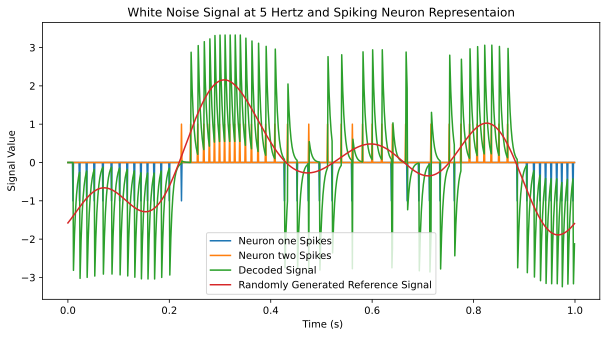

In [6]:
plt.figure(figsize=(10,5))
plt.title('White Noise Signal at %d Hertz and Spiking Neuron Representaion' % limit)
plt.xlabel(' Time (s)')
plt.ylabel('Signal Value')
neg_spikes = [-1*spike for spike in spikes[0]]
pos_spikes = spikes[1]
plt.plot(t,neg_spikes,label='Neuron one Spikes')
plt.plot(t,pos_spikes,label='Neuron two Spikes')

# Get rate decoders for neurons
rates = []
for n in pair:
    rates.append(n.rates(sig))

As = np.transpose(rates)
stddev_noise = 0.1*200
gamma_noisy = np.dot(np.transpose(As/dt),As)/S + np.power(stddev_noise,2)*np.identity(As.shape[1])
upsilon = np.dot(np.transpose(As/dt),sig)/S
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

# Compute the spikes for convolution and assign them to the A matrix
fspikes1 = np.convolve(spikes[0], h, mode='same')
fspikes2 = np.convolve(spikes[1], h, mode='same')

As = np.array([fspikes1, fspikes2]).T
xhat = np.matmul(As/dt,decoders)
plt.plot(t,xhat, label='Decoded Signal')
plt.plot(t,sig,label='Randomly Generated Reference Signal')
plt.legend()
plt.show()
     

**c) Error analysis.** Compute the RMSE of the decoding.

In [7]:
rmse = calc_rmse(sig,xhat)

print("--------------------------------------------")
print("RMSE of the LIF Neuron = ", str(rmse))
print("-----------------------------------")


--------------------------------------------
RMSE of the LIF Neuron =  0.9342988047848583
-----------------------------------


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_6908/344596861.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


--------------------------------------------------------
RMSE for each neuron group
0.5772124033708974
0.42326513579234204
0.28419148836281705
0.2206454658374372
0.18980133333276916
0.1715810723079477
------------------------------------------


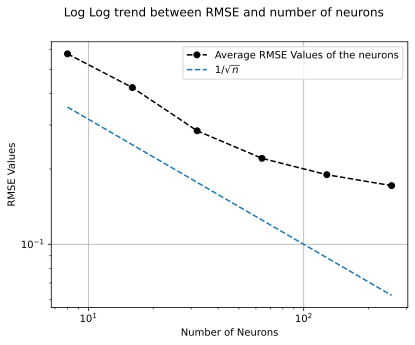

In [8]:
def generate_LIF_neurons(num):
    neurons = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
    return neurons

num_runs = 5
num_neurons = [8,16,32,64,128,256]
T, rms, dt, limit = 1, 1, 0.001, 5
rmse_vals = []

for n in num_neurons:
    neurons = generate_LIF_neurons(n)
    rmse_avg = 0
    for run in range(num_runs):
        xSignal, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit, seed=seed)
        
        # Get rate decoders for neurons
        rates = []
        spikes = []
        for neuron in neurons:
            rates.append(neuron.rates(x))
            v, num, s = neuron.spikes(xSignal,dt)
            spikes.append(s)

        N = len(rates)

        rates = np.transpose(rates)
        stddev_noise = 0.1*200
        gam = np.dot(np.transpose(rates),rates)/S + np.power(stddev_noise,2)*np.identity(rates.shape[1])
        ups = np.dot(np.transpose(rates),x)/S
        d = np.dot(np.linalg.inv(gam),ups)
        
        fspikes = [np.convolve(spike, h, mode='same') for spike in spikes]
        A = np.array(fspikes).T
        xhat = np.matmul(A/dt,d)

        rmse_avg += calc_rmse(xhat, xSignal)
    rmse_vals.append(rmse_avg/num_runs)

print('--------------------------------------------------------')
print('RMSE for each neuron group')

for val in rmse_vals:
    #print("RMSE Value for:" + str(num_neurons[val]))
    print(val)
print('------------------------------------------')

sqrtn = [1 / np.sqrt(N) for N in num_neurons]
plt.suptitle("Log Log trend between RMSE and number of neurons")
plt.loglog(num_neurons, rmse_vals,'ko--', label="Average RMSE Values of the neurons")
plt.ylabel("RMSE Values")
plt.xlabel("Number of Neurons")
plt.grid()
plt.loglog(num_neurons, sqrtn, linestyle="dashed", label='1/$\sqrt{n}$' )
plt.legend()

Noisy decoders caused it to saturate at 64 neurons. which is i think expected?

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

As the number of neurons increases, the RMSE value for the set of neurons also decreases. This means that the the accuracy of decoding is directly proportional to the number of neurons present in the decoding process.

When plotting against $\frac{1}{\sqrt{n}}$, we find it fits the curve for the most part, but since the RMSE converges.  This is expected, since as your increase your neurons, the RMSE would decrease to a converging  value. The only reason as to why it would decrease to that specific value at 64 neurons is atributed to the noise inherently present in the spikes (something that was mentioned by the prof).


# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

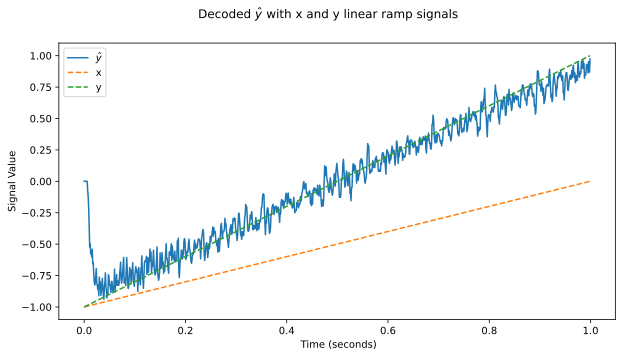

In [9]:
def generate_LIF_neuronsR1(num):
    neurons = []
    for i in range(num):
        n = LIFNeuronR1()
        neurons.append(n)
    return neurons

num_neurons = 200
t = np.arange(0,T,dt)
stddev_noise = 0.1*200

pop_one = generate_LIF_neuronsR1(200)
pop_two = generate_LIF_neuronsR1(200)

signal_one = np.linspace(-1,1,len(t))
signal_two = [2*k+1 for k in signal_one]
    
# Get rate decoders for neuron population one
rates_one = []
for neuron in pop_one:
    rates_one.append(neuron.rates(signal_one))
    
r_one = np.transpose(rates_one)
gam = np.dot(np.transpose(r_one),r_one)/S + np.power(stddev_noise,2)*np.identity(r_one.shape[1])
ups = np.dot(np.transpose(r_one),signal_two)/S
d_one = np.dot(np.linalg.inv(gam),ups)

# Get rate decoders for neuron population two
rates_two = []
for neuron in pop_two:
    rates_two.append(neuron.rates(signal_one))

r_two = np.transpose(rates_two)
gam = np.dot(np.transpose(r_two),r_two)/S + np.power(stddev_noise,2)*np.identity(r_two.shape[1])
ups = np.dot(np.transpose(r_two),signal_one)/S
d_two = np.dot(np.linalg.inv(gam),ups)

# Show behaviour of system
x = np.linspace(-1,0,len(t))
y = [2*k+1 for k in x]

spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.matmul(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.matmul(A/dt,d_two)

plt.figure(figsize=(10,5))
plt.suptitle("Decoded $\hat y$ with x and y linear ramp signals")
plt.plot(t,yhat,label='$\hat y$')
plt.plot(t,x,label='x', linestyle="dashed")
plt.plot(t,y,label='y', linestyle='dashed')
#plt.plot(t,xhat) <-- Ignore this 
plt.xlabel(' Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

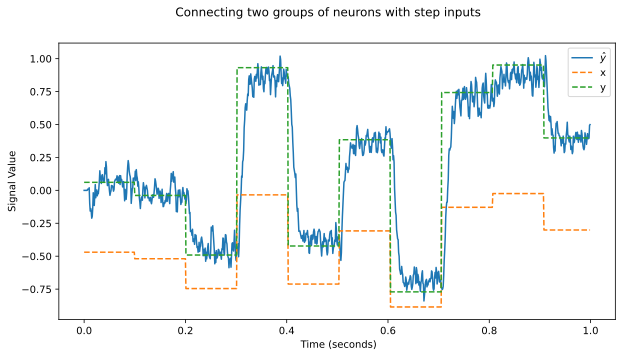

In [10]:
x = []
num = np.random.uniform(-1,0)
count = 0
for time in t:
    if count >= 100:
        num = np.random.uniform(-1,0)
        count = 0
    else:
        count += 1
    x.append(num)

y = [2*k+1 for k in x]

spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.matmul(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.matmul(A/dt,d_two)

plt.figure(figsize=(10,5))
plt.suptitle('Connecting two groups of neurons with step inputs')
plt.plot(t,yhat,label='$\hat y$')
plt.plot(t,x,label='x', linestyle="dashed")
plt.plot(t,y,label='y', linestyle="dashed")
plt.xlabel(' Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()

     

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_6908/4067908625.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


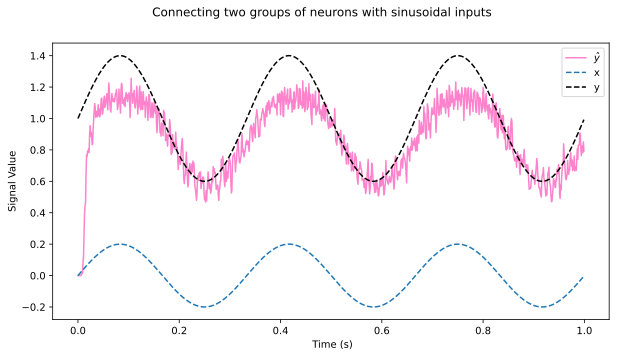

In [11]:
x = 0.2 * np.sin(6*np.pi*t)
y = [2*k+1 for k in x]


spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.matmul(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.matmul(A/dt,d_two)

cmap = cm.get_cmap('viridis')

plt.figure(figsize=(10,5))
plt.suptitle('Connecting two groups of neurons with sinusoidal inputs')
plt.plot(t,yhat,label='$\hat y$',color="xkcd:bubblegum pink")
plt.plot(t,x,label='x', linestyle="dashed")
plt.plot(t,y,label='y', linestyle="dashed", color="black")
plt.xlabel(' Time (s)')
plt.ylabel('Signal Value')
plt.legend()


**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

A delay is present that is introduced by the PSCF $h(t)$. This delay seems to be more nuanced since we have two groups of neurons connected to each other, thereby amplifying the delay and making it more apparent (sorry for the overly complicated explanation).  The decoded signal also underestimates (or rather is shifted a little down) due to the neuron saturation, i.e, the maximum value that can be faithfully represented by a neuron is $x_{max}$ = 1. 

Now beyond this value, the tuning curves would begin to flatten out which would lead to diminishing returns in the activity as $x(t)$ increases. This limits the entries in the acitivities matrix which inturn limits the decoders and the maginitude of the estimation of the signal to a value of one.

There is also alot of noise as seen in the jagged lines of the estimated output signals. This is expected since we have noise added into the deocoders, something that gets assimilated into the output estimates.

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

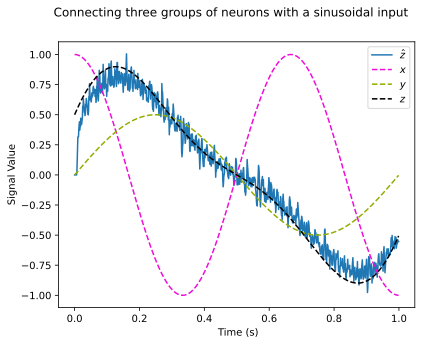

In [12]:
num_neurons = 200
t = np.arange(0,T,dt)
stddev_noise = 0.1*200

# Get populations of neurons for three groups
pop_one = generate_LIF_neuronsR1(200)
pop_two = generate_LIF_neuronsR1(200)
pop_three = generate_LIF_neuronsR1(200)

# Generate 3 signals based on how they are fed with each other
sig_one = np.linspace(-1,1,len(t))
sig_two = [2*k for k in sig_one]
sig_three = [0.5*k for k in sig_one]
        
# Get rate decoders for population 1
rates_one = []
for neuron in pop_one:
    rates_one.append(neuron.rates(sig_one))
    
r_one = np.transpose(rates_one)
gam = np.dot(np.transpose(r_one),r_one)/S + np.power(stddev_noise,2)*np.identity(r_one.shape[1])
ups = np.dot(np.transpose(r_one),sig_three)/S
d_one = np.dot(np.linalg.inv(gam),ups)

# Get rate decoders for population 2
rates_two = []
for neuron in pop_two:
    rates_two.append(neuron.rates(sig_one))

r_two = np.transpose(rates_two)
gam = np.dot(np.transpose(r_two),r_two)/S + np.power(stddev_noise,2)*np.identity(r_two.shape[1])
ups = np.dot(np.transpose(r_two),sig_two)/S
d_two = np.dot(np.linalg.inv(gam),ups)

# Get rate decoders for population 3
rates_three = []
for neuron in pop_three:
    rates_three.append(neuron.rates(sig_one))
    
r_three = np.transpose(rates_three)
gam = np.dot(np.transpose(r_three),r_three)/S + np.power(stddev_noise,2)*np.identity(r_three.shape[1])
ups = np.dot(np.transpose(r_three),sig_one)/S
d_three = np.dot(np.linalg.inv(gam),ups)

# Set population inputs as desired
# x(t) = cos(3 pi t), y = 0.5(sin(2 pi t))
x = np.cos(3*np.pi*t)
y = 0.5*np.sin(2*np.pi*t)
z = [0.5*pair[0] + 2*pair[1] for pair in zip(x,y)]

# Create Spikes for population one
spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

# Use spikes to get decoded x
fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.matmul(A/dt,d_one)

# Create spikes for population two
spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(y,dt)
    spikes_two.append(s)

# Use spikes to get decoded y
fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.matmul(A/dt,d_two)

# Add everything together with the power of superposiiton!
xy = [pair[0] + pair[1] for pair in zip(xhat,yhat)]
spikes_three = []
for neuron in pop_three:
    v, num, s = neuron.spikes(xy,dt)
    spikes_three.append(s)

# generate spikes for population three. 
# Use it to calculated zHat (decoded z)
fspikes_three = [np.convolve(s, h, mode='same') for s in spikes_three]
A = np.array(fspikes_three).T
zhat = np.matmul(A/dt,d_three)


# Plot everything that is needed, mainly zHat i guess
plt.suptitle('Connecting three groups of neurons with a sinusoidal input')
plt.plot(t,zhat,label='$\hat z$')
plt.plot(t,x,label='$x$', linestyle='dashed', color='xkcd:fuchsia')
plt.plot(t,y,label='$y$', linestyle='dashed', color='xkcd:barf green')
plt.plot(t,z,label='$z$', linestyle='dashed', color = 'black')
plt.xlabel(' Time (s)')
plt.ylabel('Signal Value')

plt.legend()
     

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_6908/344596861.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


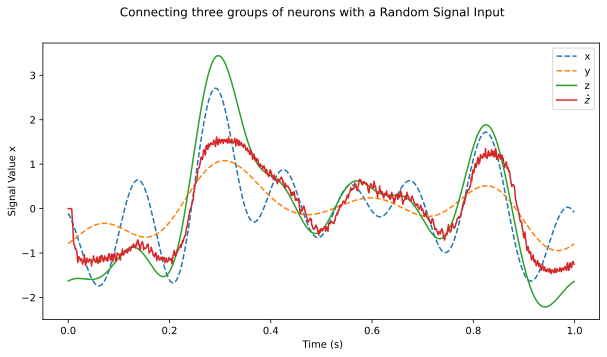

In [13]:
# Population behaviour
x, X = generate_signal(T=T,dt=dt,rms=1,limit=8, seed=seed)
y, Y = generate_signal(T=T,dt=dt,rms=0.5,limit=5, seed=seed)
z = [0.5*pair[0] + 2.0*pair[1] for pair in zip(x,y)]

spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.dot(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(y,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.dot(A/dt,d_two)

# Add together
xy = [pair[0] + pair[1] for pair in zip(xhat,yhat)]
spikes_three = []
for neuron in pop_three:
    v, num, s = neuron.spikes(xy,dt)
    spikes_three.append(s)

fspikes_three = [np.convolve(s, h, mode='same') for s in spikes_three]
A = np.array(fspikes_three).T
zhat = np.dot(A/dt,d_three)


plt.figure(figsize=(10,5))
plt.suptitle('Connecting three groups of neurons with a Random Signal Input')
plt.plot(t,x,label='x', linestyle='dashed')
plt.plot(t,y,label='y', linestyle='dashed')
plt.plot(t,z,label='z')
plt.plot(t,zhat,label='$\hat z$')
plt.xlabel(' Time (s)')
plt.ylabel('Signal Value x')
plt.legend()

Again, poor estimation arises from saturation of neurons past the [-1,1] limit
, but overall shape is preserved.

Decoded avlues also look noisy, which is expected

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [14]:
class LIF_neuron2D():

    def __init__(self,e,alpha,Jbias,tau_ref,tau_rc):
        self.e=e
        self.tau_ref=tau_ref
        self.tau_rc=tau_rc
        self.Jbias=Jbias
        self.alpha=alpha
        self.V=0.0
        self.dVdt=0.0
        self.stimulus=[]
        self.spikes=[]
        self.Vhistory=[]

    def set_sample_rates(self,x_vals):
        self.sample_x=x_vals
        self.sample_rates=[]
        for x in x_vals:
            J=self.alpha*np.dot(x,self.e)+self.Jbias
            if J>1:
                rate=1/(self.tau_ref-self.tau_rc*np.log(1-1/J))
            else:
                rate=0
            self.sample_rates.append(float(rate))
        return self.sample_rates

    def set_sample_rates_noisy(self,x_vals,noise,rng):
        self.sample_x=x_vals
        self.sample_rates_noisy=[]
        for x in x_vals:
            eta=0
            J=self.alpha*np.dot(x,self.e)+self.Jbias
            if J>1:
                rate=1/(self.tau_ref -self.tau_rc*np.log(1-1/J))
            else:
                rate=0
            if noise !=0:
                eta=rng.normal(loc=0,scale=noise)
            self.sample_rates_noisy.append(float(rate+eta))
        return self.sample_rates_noisy

    def set_spikes(self,stimulus,T,dt):
        self.stimulus=stimulus #an array
        self.spikes=[]
        self.Vhistory=[]
        ref_window=int(self.tau_ref/dt) #number of timesteps in refractory period
        for t in range(len(stimulus)):
            self.J=self.alpha*np.dot(self.stimulus[t],self.e) + self.Jbias
            self.dVdt=((1/self.tau_rc)*(self.J-self.V))
            for h in range(ref_window):   
                if len(self.spikes) >= ref_window and self.spikes[-(h+1)] == 1:
                    self.dVdt=0 
            #Euler's Method Approximation V(t+1) = V(t) + dt *dV(t)/dt
            self.V=self.V+dt*self.dVdt  
            if self.V >= 1:
                self.spikes.append(1)   # spike
                self.V=0    #reset to 0
            else:
                self.spikes.append(0) # Dont spike
                if self.V < 0: self.V=0
            self.Vhistory.append(self.V)
    def get_sample_rates(self):
        return self.sample_rates

    def get_sample_rates_noisy(self):
        return self.sample_rates_noisy

    def get_spikes(self):
        return self.spikes

def ensemble_2D(n_neurons,x_min,x_max,dx,a_min,a_max, seed,tau_ref,tau_rc,noise,T,dt,stimulus):

    dimension=2
    rng1=np.random.RandomState(seed=seed) #for neuron parameters
    a_max_array=rng1.uniform(a_min,a_max,n_neurons)

    #generate encoders over an n-dimensional hypersphere (not evenly distributed)
    angles=rng1.uniform(0,2*np.pi,n_neurons)     
    e_array=np.array([(np.cos(angles)[i],np.sin(angles)[i]) 
                    for i in range(len(angles))]) #on unit circle

    #create sample points
    x_int_array=np.array([rng1.uniform(x_min,x_max)*e_array[i]
                    for i in range(len(e_array))])  #along encoders

    x1 = np.arange(x_min, x_max, dx)
    x2 = np.arange(x_min, x_max, dx)
    x_mesh=np.vstack(np.meshgrid(x1, x2)).reshape(2,-1).T

    # Create neurons, rate neurons for decoders, spiking neurons for estimate
    neurons=[]
    spikes=[]
    for i in range(n_neurons):
        #assume e=[1...1] (len dimensions) when calculating alpha, Jbias
        x_max_D=np.full((dimension),x_max)
        x_max_dot_1=np.dot(x_max_D,np.full((dimension),1))/dimension
        x_int_dot_1=np.dot(x_int_array[i],np.full((dimension),1))/dimension
        alpha=1/(x_max_dot_1-x_int_dot_1)*\
                (-1+1/(1-np.exp((tau_ref-1/a_max_array[i])/tau_rc)))
        Jbias=1-alpha*x_int_dot_1
        n=LIF_neuron2D(e_array[i],alpha,Jbias,tau_ref,tau_rc)
        n.set_sample_rates(x_mesh)
        n.set_sample_rates_noisy(x_mesh,noise,rng1)
        n.set_spikes(stimulus,T,dt)
        neurons.append(n)
        spikes.append(n.get_spikes())

    return neurons, spikes

def get_rate_decoders(neurons,noise,function=lambda x: x):

    A_T=[]
    for n in neurons:
        A_T.append(n.get_sample_rates())
    A_T=np.matrix(A_T)
    A=np.transpose(A_T)
    x=np.matrix(neurons[0].sample_x) # Use x_sample, not x_t, to define rates
    upsilon=A_T*function(x)/len(x)
    gamma=A_T*A/len(x) + np.identity(len(neurons))*noise**2
    d=np.linalg.inv(gamma)*upsilon
    return d

def get_rate_estimate(neurons,d,noise):

    xhat=[]
    for j in range(len(neurons[0].sample_x)):
        xhat_i=0
        for i in range(len(neurons)):
            if noise != 0:
                a_ij=neurons[i].get_sample_rates_noisy()[j]
                d_i=np.array(d[i])
                xhat_i+=(a_ij*d_i).flatten()
            else:
                a_ij=neurons[i].get_sample_rates()[j]
                d_i=np.array(d[i])
                xhat_i+=(a_ij*d_i).flatten()
        xhat.append(xhat_i)
    xhat=np.array(xhat)
    return xhat

def get_spike_estimate(spikes,h,d):

    timesteps=len(spikes[0])
    dimension=d[0].shape[1]
    n_neurons=len(d)
    xhat=np.zeros((timesteps,dimension))
    for i in range(n_neurons):
        decoder=d[i]
        filtered_spikes=np.convolve(spikes[i],h,mode='full')\
            [:timesteps].reshape(timesteps,1)
        value=filtered_spikes*decoder
        xhat+=value

    return xhat

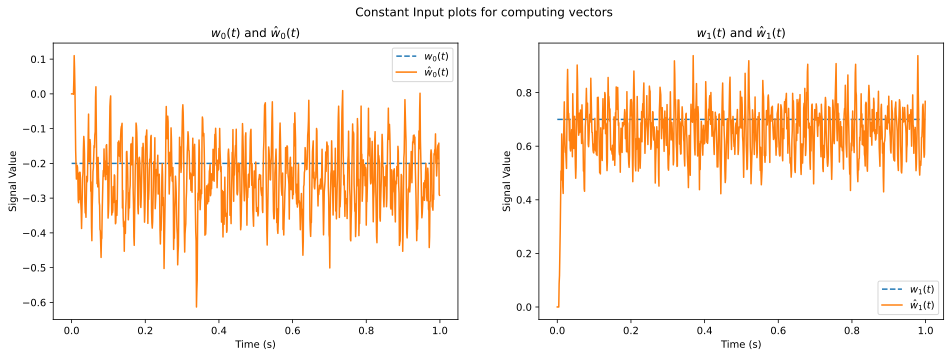

In [15]:
# Set params
num_neurons, dimension=200, 2
a_min, a_max=100, 200
x_min, x_max=-1, 1
dx=0.05
tau_ref, tau_rc=0.002, 0.02
T=1
dt=0.001
n=0
rms=0.5
noise=0.1*a_max
seed=seed
t=np.arange(1000)*dt

# Set post-synaptic current temporal filter using t^n where n = 0
# tau_synapse=0.005          
# h=t**n*np.exp(-t/tau_synapse)
# h=h/np.sum(h*dt)

t_h = np.arange(1000)*dt
h = (1/tau)* np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = (h/np.linalg.norm(h,1))*1000

# Signals with set constants
x_t=np.full((len(t),dimension),[0.5,1])
y_t=np.full((len(t),dimension),[0.1,0.3])
z_t=np.full((len(t),dimension),[0.2,0.1])
q_t=np.full((len(t),dimension),[0.4,-0.2])
w_t=x_t-3*y_t+2*z_t-2*q_t

# Get the transforms
f1=lambda x: x
f2=lambda y: y
f3=lambda z: z
f4=lambda q: q
f5=lambda w: w

# Neuron populations/ensemble for each stimulus
n1,spikes1=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
n2,spikes2=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
n3,spikes3=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=z_t)
n4,spikes4=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=q_t)

# Get decoders for each of the ensembles
d1=get_rate_decoders(n1,noise,f1)
d2=get_rate_decoders(n2,noise,f2)
d3=get_rate_decoders(n3,noise,f3)
d4=get_rate_decoders(n4,noise,f4)

# Get the estimations for each of the signals x, y, z,and q
f_xhat=get_spike_estimate(spikes1,h,d1)   
f_yhat=get_spike_estimate(spikes2,h,d2)
f_zhat=get_spike_estimate(spikes3,h,d3)
f_qhat=get_spike_estimate(spikes4,h,d4)

# Transformations for the signal
feedforward=f_xhat-3*f_yhat+2*f_zhat-2*f_qhat
n5,spikes5=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=feedforward)
d5=get_rate_decoders(n5,noise,f5)
f_what=get_spike_estimate(spikes5,h,d5)


# plot signal, transformed signal, and estimate
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(t,w_t[:,0], label='$w_0(t)$', linestyle ="dashed")#=x(t)-3*y(t)+2*z(t)-2*q(t)$')
ax1.plot(t,f_what[:,0], label='$\hat{w}_0(t)$')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal Value')
ax1.set_title('$w_0(t)$ and $\hat w_0(t)$')
ax1.legend()

ax2.plot(t,w_t[:,1], label='$w_1(t)$', linestyle ="dashed")#=x(t)-3*y(t)+2*z(t)-2*q(t)$')
ax2.plot(t,f_what[:,1], label='$\hat{w}_1(t)$')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Signal Value')
ax2.set_title('$w_1(t)$ and $\hat w_1(t)$')
plt.suptitle('Constant Input plots for computing vectors')
ax2.legend()
    


**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

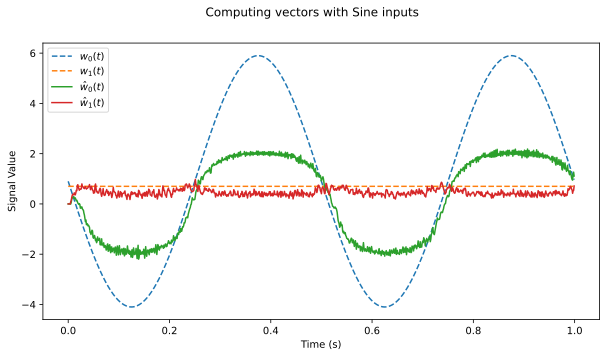

In [16]:
# Set the same post synaptic filter (wanted to use a different way instead of calling
# the np.normalize func)
t_h = np.arange(1000)*dt
h = (1/tau)* np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = (h/np.linalg.norm(h,1))*1000

# Signals with set constants
x_t=np.full((len(t),dimension),[0.5,1])
y_t=np.vstack([np.sin(4*np.pi*t),0.3*np.cos(0*t)]).T
z_t=np.full((len(t),dimension),[0.2,0.1])
q_t=np.vstack([np.sin(4*np.pi*t),-0.2*np.cos(0*t)]).T
w_t=x_t-3*y_t+2*z_t-2*q_t
w_t=x_t-3*y_t+2*z_t-2*q_t

# Get the transforms
f1=lambda x: x
f2=lambda y: y
f3=lambda z: z
f4=lambda q: q
f5=lambda w: w

# Neuron populations/ensemlble for each stimulus
n1,spikes1=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=x_t)
n2,spikes2=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=y_t)
n3,spikes3=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=z_t)
n4,spikes4=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=q_t)

# Get decoders
d1=get_rate_decoders(n1,noise,f1)
d2=get_rate_decoders(n2,noise,f2)
d3=get_rate_decoders(n3,noise,f3)
d4=get_rate_decoders(n4,noise,f4)

# Get the estimations
f_xhat=get_spike_estimate(spikes1,h,d1)   
f_yhat=get_spike_estimate(spikes2,h,d2)
f_zhat=get_spike_estimate(spikes3,h,d3)
f_qhat=get_spike_estimate(spikes4,h,d4)

# Transformations for the signal
feedforward=f_xhat-3*f_yhat+2*f_zhat-2*f_qhat
n5,spikes5=ensemble_2D(num_neurons,x_min,x_max,dx,a_min,a_max,seed,tau_ref,tau_rc,noise,T,dt,stimulus=feedforward)
d5=get_rate_decoders(n5,noise,f5)
f_what=get_spike_estimate(spikes5,h,d5)


# plot signal, transformed signal, and estimate
plt.figure(figsize=(10,5))
plt.suptitle('Computing vectors with Sine inputs')
plt.plot(t,w_t[:,0], label='$w_0(t)$', linestyle="dashed")
plt.plot(t,w_t[:,1], label='$w_1(t)$', linestyle="dashed")
plt.plot(t,f_what[:,0], label='$\hat{w}_0(t)$')
plt.plot(t,f_what[:,1], label='$\hat{w}_1(t)$')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.legend()

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

The two graphs seem to resemble a similar phenomenon as seen in question 4.

There is noise present in both the graphs, similar to q4. This is due to the addional noise added into the decoders that later got assimilated into the estimated/approximated output of the signals

There is also a delay and a smoothing , something that had popped up due to the nature of the PSCF adding a delay (something to do with time constant fo the neurons)

We can see that there is an error that exists between both the neuron groups. This gets added up as the groups get connected with each other (propogates between each of the neuron groups as they get added up and get connected).  

We can also see there is an underestimation noticeable in the plot for part b) due to the neuron saturation present in the LIF neurons.This would mean that, since the neurons are capped at a saturation level 1, functions that extend beyond this threshold would have a tough time getting repesented/estimated only because it simply isnt allowed to do that - or simply, functions with a higher input will not be able to be represented (which in turn leads to saturation). It can also fire oh so fast with the designated refactory period




Heres a meme of a cat to end things off. Thanks for your time in reading this notebook

![ChessUrl](https://media.tenor.com/66xoSIRmYu0AAAAC/cat-bop.gif "cat")
